In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone "https://github.com/maria-natale/ProgettoFVAB"

Cloning into 'ProgettoFVAB'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 251 (delta 92), reused 138 (delta 33), pack-reused 0
Receiving objects: 100% (251/251), 1.23 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [106]:
!python "/content/ProgettoFVAB/Code/create_datasetNUOVO.py"

(470, 2)
(155, 2)
(163, 2)
100% 470/470 [03:13<00:00,  2.43it/s]
100% 858/858 [05:03<00:00,  2.82it/s]
442it [01:18,  5.60it/s]
100% 155/155 [00:21<00:00,  7.12it/s]
100% 858/858 [00:08<00:00, 102.85it/s]
143it [00:23,  6.19it/s]
100% 163/163 [00:30<00:00,  5.29it/s]
100% 858/858 [00:08<00:00, 96.10it/s]
160it [00:26,  6.11it/s]


In [107]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [20]:
import os
import pandas as pd
import numpy as np

path_git = '/content/ProgettoFVAB'
filename = 'all'
path_drive = '/content/drive/MyDrive/Casillo&Natale/dataset'
dataset_dir = 'dataset_all/datasetCSV'
LANGUAGES = {
  1:'Italiano',
  2:'Inglese',
  3: 'Tedesco',
  4:'Spagnolo',
  5: 'Olandese',
  6:'Russo',
  7: 'Giapponese'}
LANGUAGES_N = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:6
}
"""LANGUAGES = {
    4:'Spagnolo',
  7: 'Giapponese'}
LANGUAGES_N = {
    4:0,
    7:1
}"""

MAX_LINES = 350

# Caricamento dei dati

In [21]:
# load dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header= None)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    loaded = list()
    for name in filenames:
        data = read_csv(prefix+name)
        data = scaler.fit_transform(data)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix= ''):
    filepath = path_drive+'/'+dataset_dir+'/features/'
    os.chdir(os.path.join(filepath, group))
    filenames = []
    filenames = [group+'/feature'+str(i)+'.csv' for i in range(0,66)]
    # load input data
    X= load_group(filenames, filepath)
    #load y 
    os.chdir(os.path.join(path_drive, dataset_dir, 'csv'))
    y = read_csv(filename+'_'+group.split('_')[0]+'_targets_1.csv')
    # load class output
    return X,y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix)
    print(testX.shape, testy.shape)
    validationX, validationy = load_dataset_group('validation', prefix)
    trainy['language'] = trainy['language'].map(LANGUAGES_N)
    testy['language'] = testy['language'].map(LANGUAGES_N)
    validationy['language'] = validationy['language'].map(LANGUAGES_N)
    trainy = to_categorical(trainy, len(LANGUAGES_N))
    testy = to_categorical(testy, len(LANGUAGES_N))
    validationy = to_categorical(validationy, len(LANGUAGES_N))
    print(trainX.shape, trainy.shape, testX.shape, testy.shape, validationX.shape, validationy.shape)
    return trainX, trainy, testX, testy, validationX, validationy

    
  

# Definizione del modello

In [22]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

def create_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], len(LANGUAGES_N.keys())
    # Initialising the RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (n_timesteps, n_features))))
    model.add(Dropout(0.5))

    # Adding a second LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    model.add(Dropout(0.5))

    # Adding a third LSTM layer and Dropout layer
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(Dropout(0.5))

    # Adding the output layer
    model.add(Dense(n_outputs, activation='softmax'))

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy']
    )

    return model
    



# Sperimentazione Spagnolo Giapponese con Early Stopping

In [23]:
def run_experiment(model, trainX, trainy, validationX, validationy, testX, testy):
  verbose, epochs, batch_size = 0, 100, 16
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, verbose = verbose, validation_data = (validationX, validationy), callbacks = [es]) 
  #model.summary()
  value = model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions, value[1]


In [24]:
# run the experiment
with tf.device('/device:GPU:0'):
  trainX, trainy, testX, testy, validationX, validationy = load_dataset(path_drive+'/'+dataset_dir)
  history_list = []
  prediction_list = []
  values = []
  for i in range(1):
    model = create_model(trainX, trainy, validationX, validationy)
    history, predictions, value = run_experiment(model, trainX, trainy, validationX, validationy, testX, testy)
    history_list.append(history)
    prediction_list.append(predictions)
    values.append(value)
  print(mean(values))

(462, 350, 66) (462, 1)
(160, 350, 66) (160, 1)
(462, 350, 66) (462, 7) (160, 350, 66) (160, 7) (145, 350, 66) (145, 7)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 00028: early stopping
5/5 [==============================] - 2s 63ms/step - loss: 1.8366 - accuracy: 0.5312


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 2 0 0 1 0 0 0 0 4 4 0 1 0 4 0 1 1 2 2 0 0 6 0 0 4 0 0 1 0 2 2 0 0
 0 3 0 4 1 1 1 0 0 1 1 6 4 4 4 4 4 4 0 4 4 0 0 0 1 1 1 1 5 5 4 4 5 5 5 5 6
 6 4 4 5 5 3 2 4 4 4 4 4 4 4 4 4 2 2 6 3 4 4 4 6 5 4 4 4 4 4 4 4 4 4 4 4 6
 6 4 0 4 4 4 0 4 4 3 4 4 4 4 4 5 6 4 4 6 4 4 6 4 4 4 4 4 4 4 6 2 2 4 1 6 1
 2 2 6 6 6 6 0 0 0 0 0 0]
0.53125


In [25]:
predictions = prediction_list[0]

In [27]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

testy = np.argmax(testy, axis=1)
vis_arr = multilabel_confusion_matrix(testy, predictions, labels = list(LANGUAGES_N.values()))
print(vis_arr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES_N.values()):
    fpr[i], tpr[i], _ = roc_curve(testy == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])



[[[116  22]
  [  6  16]]

 [[134   3]
  [ 10  13]]

 [[141   9]
  [  7   3]]

 [[134   1]
  [ 22   3]]

 [[ 86  27]
  [ 11  36]]

 [[144   2]
  [  6   8]]

 [[130  11]
  [ 13   6]]]


Text(132.0, 0.5, 'predetti')

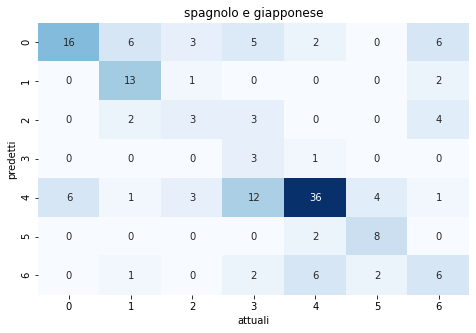

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

valori=pd.crosstab(predictions,testy)
fig=plt.figure(figsize=(17,5))
ax1=plt.subplot(121)
ax1.set_title("spagnolo e giapponese")
sns.heatmap(valori,annot=True,cmap="Blues",cbar=False)
plt.xlabel("attuali") 
plt.ylabel("predetti")


CONFUSION MATRIX

16 22 6 116
13 3 10 134
3 9 7 141
3 1 22 134
36 27 11 86
8 2 6 144
6 11 13 130


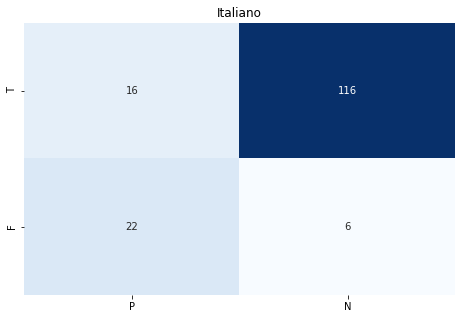

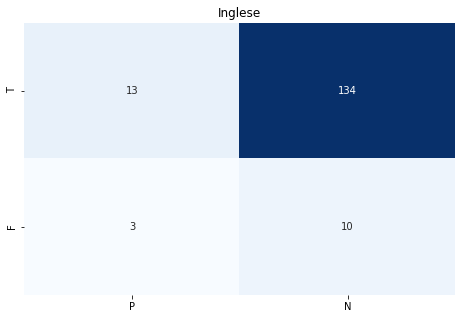

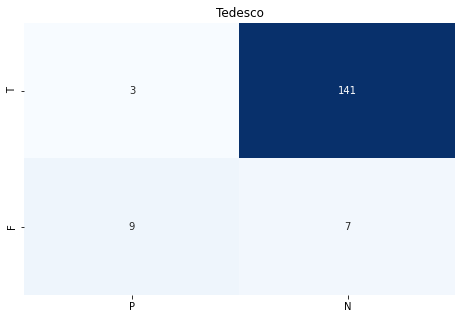

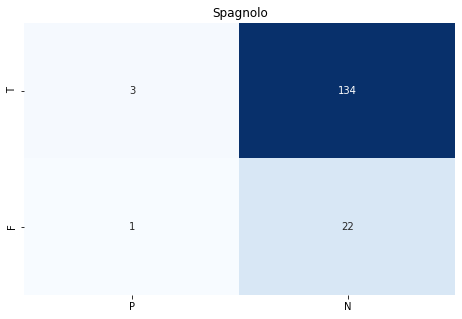

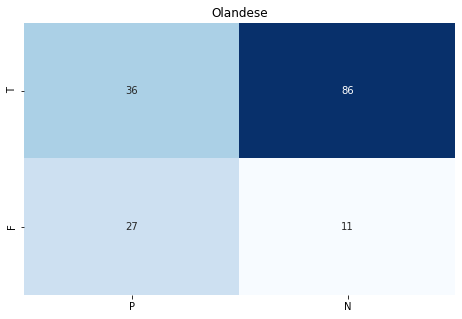

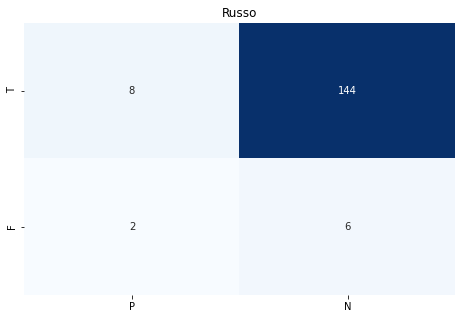

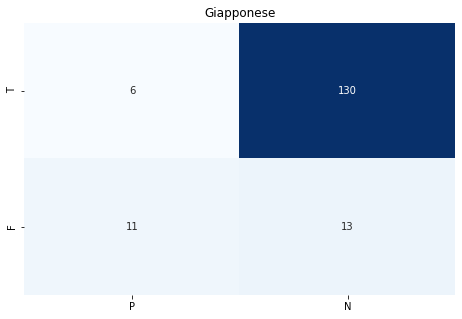

In [30]:
for i in range (valori.shape[0]):
  TP= valori.iloc[i,i]
  FP= valori.iloc[i,:].sum()-TP
  FN= valori.iloc[:,i].sum()-TP
  TN= valori.sum().sum() - TP - FP - FN
  print(TP,FP,FN,TN)
  #b=[[TP,FP],[FN,TN]]
  b=[[TP,TN],[FP,FN]]
  fig=plt.figure(figsize=(17,5))
  ax1=plt.subplot(121)
  sns.heatmap(b,annot=True,cmap="Blues",cbar=False,fmt = "g")
  #plt.xlabel("POSITIVI") 
  #plt.ylabel("NEGATIVI")
  tick_marks = [0.5,1.5]
  plt.title(LANGUAGES[i+1])
  plt.xticks(tick_marks, ["P","N",])
  plt.yticks(tick_marks, ["T","F"])

ROC CURVE

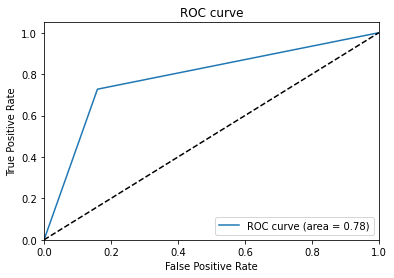

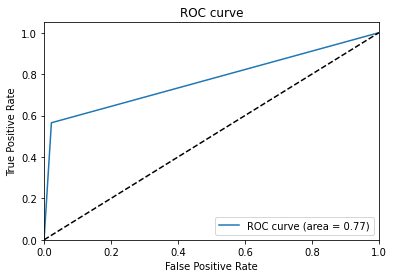

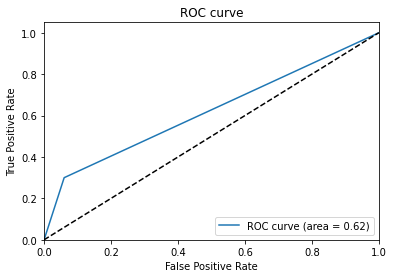

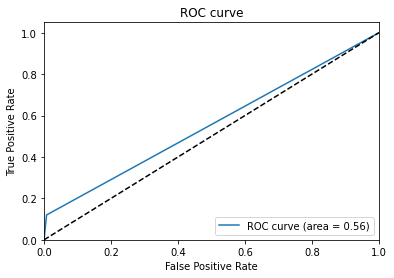

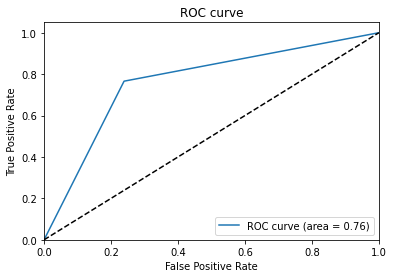

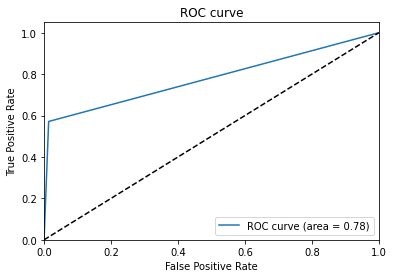

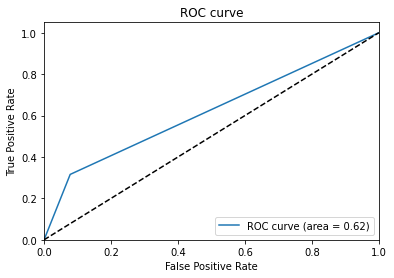

In [31]:
import matplotlib.pyplot as plt

# Plot of a ROC curve for a specific class
for i in list(LANGUAGES_N.values()):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
MODEL ACCURACY

In [32]:
history = history_list[0]

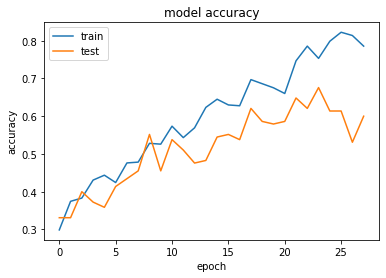

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

MODEL LOSS

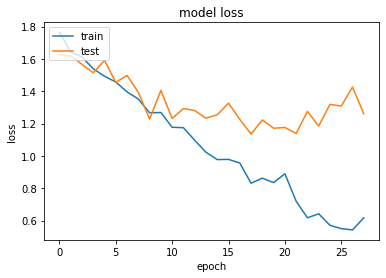

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sperimentazione Spagnolo Giapponese senza early stopping

In [ ]:
def run_experiment_without_es(model, trainX, trainy, testX, testy):
  model = create_model(trainX, trainy, testX, testy)
  verbose, epochs, batch_size = 0, 30, 32
  model = create_model(trainX, trainy,  testX, testy)
  history = model.fit(trainX, trainy, epochs = epochs, batch_size = batch_size, validation_data = (testX, testy)) 
  model.summary()
  model.evaluate(testX, testy)
  predictions = model.predict_classes(testX) 
  print(predictions)
  return history, predictions

In [ ]:
# run the experiment
trainX, trainy, testX, testy = load_dataset(path_drive+'/'+dataset_dir)
model = create_model(trainX, trainy, testX, testy)
history, predictions = run_experiment_without_es(model, trainX, trainy, testX, testy)

(195, 350, 66) (195, 1)
(55, 350, 66) (55, 1)
(195, 350, 66) (195, 2) (55, 350, 66) (55, 2)
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


7/7 [==============================] - 33s 3s/step - loss: 0.7127 - accuracy: 0.6071 - val_loss: 0.6553 - val_accuracy: 0.5818
Epoch 2/30
7/7 [==============================] - 14s 2s/step - loss: 0.6827 - accuracy: 0.5665 - val_loss: 0.6899 - val_accuracy: 0.6909
Epoch 3/30
7/7 [==============================] - 15s 2s/step - loss: 0.6356 - accuracy: 0.6256 - val_loss: 0.6154 - val_accuracy: 0.7091
Epoch 4/30
7/7 [==============================] - 15s 2s/step - loss: 0.6403 - accuracy: 0.6407 - val_loss: 0.6146 - val_accuracy: 0.6545
Epoch 5/30
7/7 [==============================] - 15s 2s/step - loss: 0.5808 - accuracy: 0.6736 - val_loss: 0.5885 - val_accuracy: 0.6909
Epoch 6/30
7/7 [==============================] - 17s 2s/step - loss: 0.6125 - accuracy: 0.6749 - val_loss: 0.5640 - val_accuracy: 0.7091
Epoch 7/30
7/7 [==============================] - 15s 2s/step - loss: 0.5235 - accuracy: 0.7260 - val_loss: 0.6184 - val_accuracy: 0.6000
Epoch 8/30
7/7 [=============================

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1]


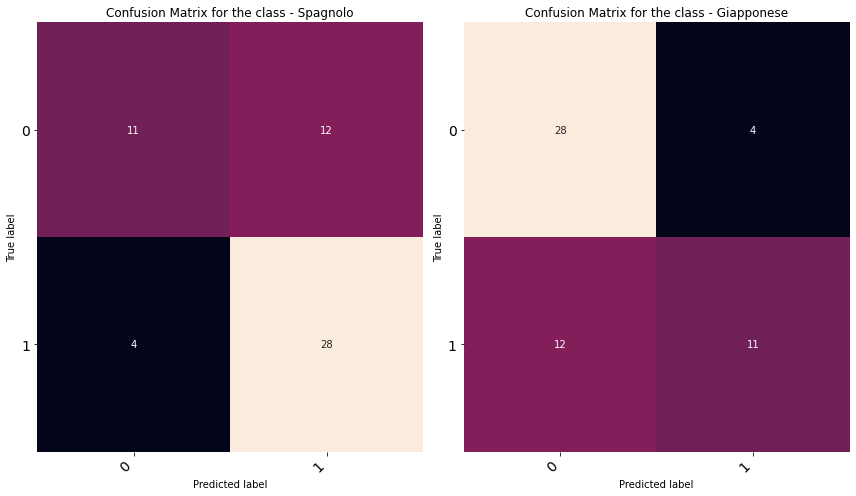

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
labels = list(LANGUAGES.values())
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, list(LANGUAGES_N.values()))
    
fig.tight_layout()
plt.show()

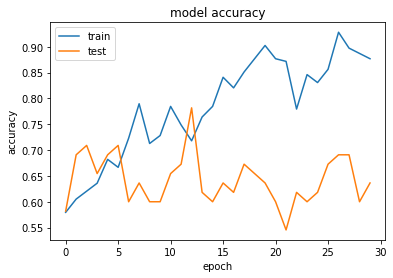

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

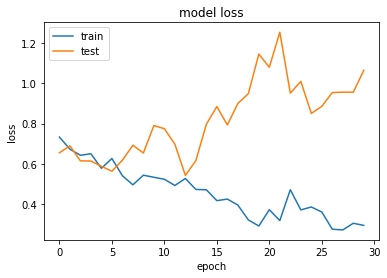

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()